In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
from mne.time_frequency import tfr_array_morlet

os.chdir('../..')

In [2]:
subject_id = 8
trial_id = 1

eeg_clean_path = f"./Generated/Data/S_{subject_id}/Trial_{trial_id}/EEG_clean.fif"
experiment_path = f"./Generated/Data/S_{subject_id}/Trial_{trial_id}/Experiment.json"

# Load the .fif file
raw = mne.io.read_raw_fif(eeg_clean_path , preload=True, verbose=False)
raw.pick_types(eeg=True, verbose=False)  # только EEG-каналы
sr = int(raw.info['sfreq'])  # sampling rate

# Load experiment sequence
with open(experiment_path,'r') as f:
    experiment_seq = json.load(f)


/tmp/ipykernel_11738/3686806336.py:8: RuntimeWarning: This filename (./Generated/Data/S_8/Trial_1/EEG_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_clean_path , preload=True, verbose=False)


# All experiment spectrum
Get all the blocks except first 30 and 300 sec rest blocks, and plot the spectrum for all subjects.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


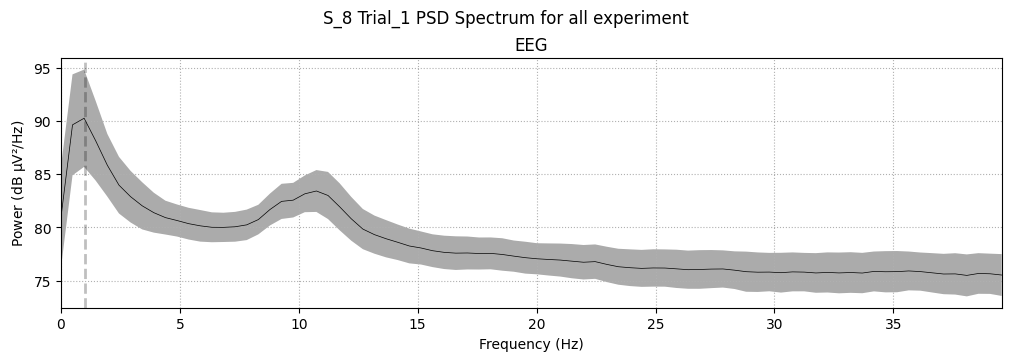

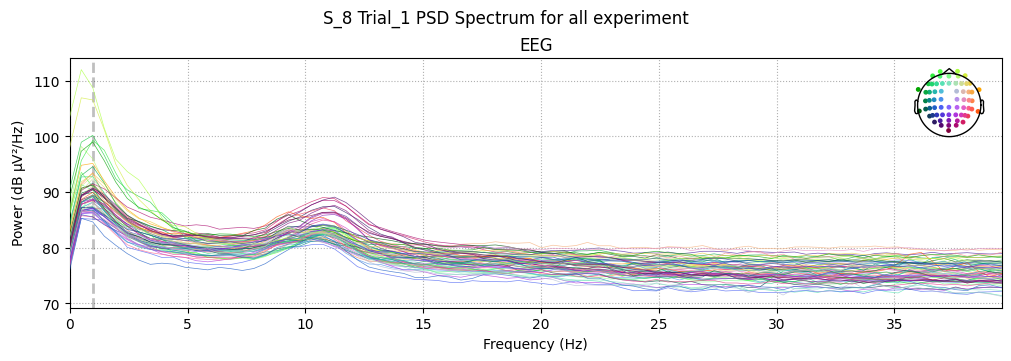

In [3]:
# Фильтруем все блоки кроме 300 sec и 30 sec rest
clean_blocks = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if not (block_data['type'] == 'rest' and (block_data['content']['duration'] == 300 or block_data['content']['duration'] == 30))
]

# Соберем отрезки с execution
epochs = []
for start_time, duration in clean_blocks:
    start_sample = int(start_time)
    stop_sample = min(int((start_time + duration)), len(raw) / sr - 0.001)
    segment = raw.copy().crop(tmin=start_sample, tmax=stop_sample)
    epochs.append(segment)

# Объединяем все execution-сегменты
raw_all = mne.concatenate_raws(epochs)

# Путь к выходной директории
out_dir = "./Generated/Figures/Spectral_Analysis/Temp"
os.makedirs(out_dir, exist_ok=True)

title = f"S_{subject_id} Trial_{trial_id} PSD Spectrum for all experiment"

# Рисуем усредненный PSD
fig1 = raw_all.plot_psd(fmax=40, average=True, show=False)
fig1.suptitle(title)
fig1.savefig(os.path.join(out_dir, f"S_{subject_id}_Trial_{trial_id}_PSD_All_avg.png"))

# Рисуем PSD для всего raw_all
fig2 = raw_all.plot_psd(fmax=40, show=False)
fig2.suptitle(title)
fig2.savefig(os.path.join(out_dir, f"S_{subject_id}_Trial_{trial_id}_PSD_All.png"))

plt.show()

# Опционально: закрываем фигуры чтобы освободить память
plt.close(fig1)
plt.close(fig2)

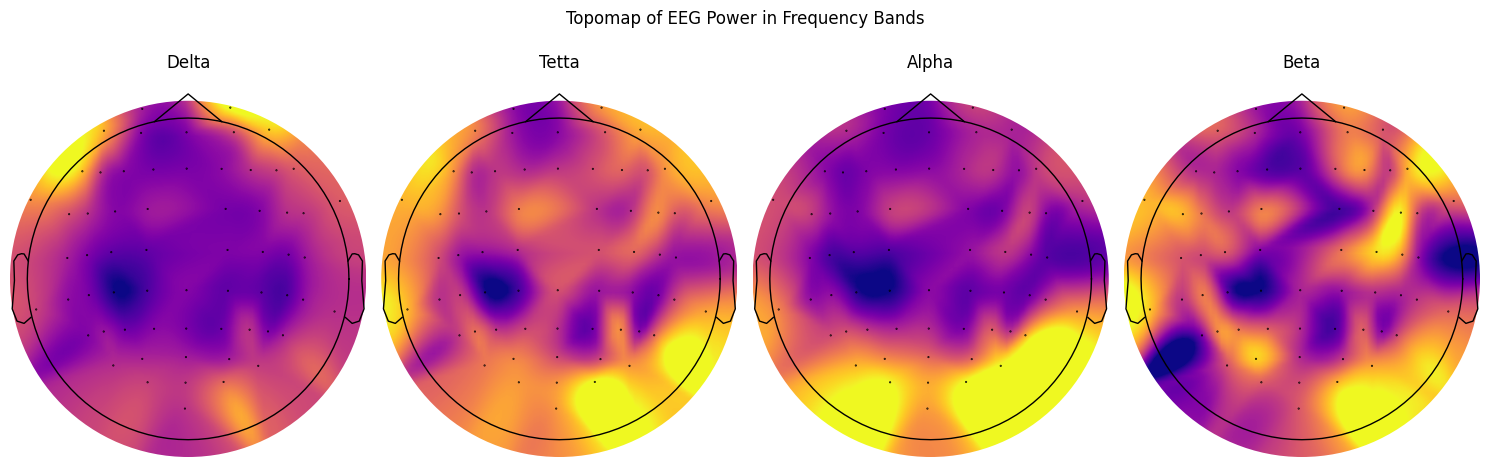

In [4]:
# Параметры PSD
psd = raw_all.compute_psd(fmin=1, fmax=40, n_fft=2048, verbose=False)
psds_data = 10 * np.log10(psd.get_data())  # [n_channels, n_freqs]
freqs = psd.freqs

# Усреднение по частотным диапазонам
band_limits = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Alpha': (7, 13),
    'Beta': (13, 30)
}

# Отрисовка топомап
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for ax, (band_name, (fmin_band, fmax_band)) in zip(axes, band_limits.items()):
    freq_mask = (freqs >= fmin_band) & (freqs <= fmax_band)
    psds_band = psds_data[:, freq_mask].mean(axis=1)

    vmin = np.min(psds_band)
    vmax = np.max(psds_band)

    mne.viz.plot_topomap(
        psds_band, raw_all.info, axes=ax, show=False,
        cmap='plasma', contours=0, vlim=(vmin, vmax)
    )
    ax.set_title(f'{band_name}')

plt.suptitle("Topomap of EEG Power in Frequency Bands")
plt.tight_layout()

out_dir = "./Generated/Figures/Spectral_Analysis/Temp/"

# Сохраняем график
fig.savefig(f"{out_dir}S_{subject_id}_Trial_{trial_id}_Freq_Bands_Local.png", dpi=100)

plt.show()
pass